# Portfolio function

In [33]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime as dt
import time
from pypfopt import expected_returns, risk_models
from sklearn.linear_model import LinearRegression

In [34]:
df = pd.read_excel('merged_final.xlsx')
adj = pd.read_excel('adj_close_664.xlsx')
adj.set_index('Date', inplace = True)
adj.index = pd.to_datetime(adj.index)
tick_ca  = list(df_ca.columns)
tick_ipo = list(adj.columns)

In [35]:
df_ca = pd.read_excel('USD_final prices cryptossets (2021-07-16) NOband.xlsx')
df_ca.set_index('dates', inplace = True)
df_ca.index = pd.to_datetime(df_ca.index)
tick_ca  = list(df_ca.columns)

In [50]:
def my_portfolio(df_ipo, df_ca, df_info, max_size_alloc=500, window=30,
                 start_date=dt.datetime(2016, 10, 10), end_date=dt.datetime(2021, 4, 15),
                 expected_return='mean_hist', sharpe_pf = 1):
    '''
    Firstly import all the dataset needed to compute markets returns,
    and create empty variables and dataframe for the function.
    '''
    df_russell = pd.read_csv('TVC_RUA, 1D.csv')
    df_russell.set_index('time', inplace = True)
    df_russell.index = pd.to_datetime(df_russell.index)
    df_mktcap = pd.read_csv('CRYPTOCAP_TOTAL, 1D.csv')
    df_mktcap.set_index('time', inplace = True)
    df_mktcap.index = pd.to_datetime(df_mktcap.index)
    delta = dt.timedelta(days=1)
    tick_ca  = list(df_ca.columns)[1:]
    tick_ipo = list(df_ipo.columns)[1:]
    PF = {'dates': [],
          'ticker': [],
          'asset_class': [],
          'open_price': [],
          'size_unit': [],
          'position_value': [],
          'sell_date': [],
          'sell_price': [],
          'return': [],
          'std_interval': []}
    PF = pd.DataFrame(PF)

    PF_valuation = {'dates': [],
                    'active_investments': [],
                    'realised_P/L_ca': [],
                    'realised_P/L_IPO': [],
                    'daily_value': []}

    PF_valuation = pd.DataFrame()
    counter = 0
    err_mess = []
    if expected_return == 'mean_hist':
        method = 'mean_hist'
    elif expected_return == 'CAPM':
        method = 'CAPM'
    else:
        print('The selected method is not correct. Please choose between CAPM and mean_hist')
        
            

    '''
    Here start the processing of data
    '''
    
    while start_date <= end_date:
        start_date += delta

        '''
        For each day of the while loop I'm iterating over all tickers 
        (here can be optimised deleting the tickers once selected)
        to find the first valid data aka the first trading day price.
        Need to create the portfolio DF that contains the operations outside every loop.
        '''

        for k in df_info['ticker'][df_info['asset_class'] == 'IPO']:
            ix = df_ipo[k].first_valid_index()
            if ix == start_date:
                # print(k, ix, start_date)
                price = df_ipo[k][ix]
                size_un = max_size_alloc // price

                PF = PF.append({'dates': ix,
                                'ticker': k,
                                'asset_class': 'IPO',
                                'open_price': round(price, 3),
                                'size_unit': size_un,
                                'position_value': size_un * price,
                                'sell_date': 0,
                                'sell_price': 0,
                                'return': 0,
                                'std_interval': 0}, ignore_index=True)

###cryptoassets
        for k in df_info['ticker'][df_info['asset_class'] == 'cryptoasset']:
            try:
                ix = df_ca[k].first_valid_index()
                if ix == start_date:
                    # print(k, ix, start_date)
                    price = df_ca[k][ix]
                    size_un = max_size_alloc // price

                    PF = PF.append({'dates': ix,
                                    'ticker': k,
                                    'asset_class': 'cryptoasset',
                                    'open_price': round(price, 6),
                                    'size_unit': size_un,
                                    'position_value': size_un * price,
                                    'sell_date': 0,
                                    'sell_price': 0,
                                    'return': 0,
                                    'std_interval': 0}, ignore_index=True)
            except:
                err_mess = err_mess + ['{}'.format(k)]

                
          # fin qui deve funzionare      
                
        '''
        Insert here the portfolio value computation.
        The computation will append only on business days.
        '''
        daily_P_L_ipo = 0
        if start_date in list(df_ipo.index):
            for k in PF['ticker']:
                
                if k in tick_ipo:
                    cond = (PF['position_value'] == 0) & (PF['asset_class'] == 'IPO')
                    P_L = (PF['sell_price'].loc[cond] - PF['open_price'].loc[cond]) * PF['size_unit'].loc[cond]
                    daily_P_L_ipo = sum(P_L)                           
            P_L = (PF['sell_price'].loc[PF['position_value'] == 0] - PF['open_price'].loc[PF['position_value'] == 0]) * \
                PF['size_unit'].loc[PF['position_value'] == 0]
            daily_P_L = sum(P_L)
            today = df_ipo.loc[start_date]
            tick_list = list(PF['ticker'][PF['asset_class'] == 'IPO'][PF['position_value'] != 0])
            sizes = np.array(PF['size_unit'][PF['asset_class'] == 'IPO'][PF['position_value'] != 0])
            todays = sum(np.array(today[tick_list])*sizes)
            
            today_ca = df_ca.loc[start_date]
            tick_list_ca = list(PF['ticker'][PF['asset_class'] == 'cryptoasset'][PF['position_value'] != 0])
            sizes = np.array(PF['size_unit'][PF['asset_class'] == 'cryptoasset'][PF['position_value'] != 0])
            todays_ca = sum(np.array(today_ca[tick_list_ca])*sizes)
            
            
            PF_valuation = PF_valuation.append({'dates': start_date,
                                                'active_investments': sum(PF['position_value'][PF['sell_price'] ==0]),
                                                'realised_P/L': daily_P_L,
                                                'realised_P/L_IPO': daily_P_L_ipo,
                                                'daily_value': todays+todays_ca}, ignore_index=True)
        
        
        
        '''
        Check the investment period.
        '''
        temp_tick = []
        for k in PF['dates']:
            if start_date == k + dt.timedelta(window):
                temp_tick = PF['ticker'][PF['dates'] == k]


        '''
        Compute the return after -window- days and the risk,
        then take an action 
        Problem solved: errors caused by the days in which the marke tis closed. 
        While lopp to resolve this problem.
        '''
        
        '''
        Definition of mu (expected return) depending on the selected method.
            
        '''
        start = 0 
        end = 0
        for i in temp_tick:
            start = PF['open_price'][PF['ticker'] == i]
            # start ok
            tempdate = start_date
            if tempdate not in list(df_ipo.index):
                while tempdate not in list(df_ipo.index):
                    counter += 1
                    tempdate += dt.timedelta(days=1)
            

            
            if i in tick_ipo:       
                end = df_ipo[i].loc[tempdate]
                intervall = df_ipo[i][tempdate - dt.timedelta(window + counter):tempdate]
                
                if method == 'mean_hist':
                    mu = expected_returns.mean_historical_return(pd.DataFrame(intervall), frequency=window)
                elif method == 'CAPM':
                    df_ = pd.DataFrame(df_ipo[i][df_ipo[i].first_valid_index():df_ipo[i].first_valid_index()+ dt.timedelta(window)])
                    df_['mkt']= df_russell['close'][df_ipo[i].first_valid_index():df_ipo[i].first_valid_index()+ dt.timedelta(window)]
                    returns_df = df_.pct_change(1).dropna()
                    if len(returns_df[i]):
        
                        x = np.array(returns_df[i]).reshape((-1,1))
                        y = np.array(returns_df['mkt'])
                        model = LinearRegression().fit(x, y)
                        mu = 0.01 + model.coef_*((df_['mkt'].pct_change(1) + 1).cumprod()[-1]-1 - 0.01)
                        #print('Beta = ', model.coef_)
                
                    
                std = (intervall.pct_change(1)-0.01).std()
                sharpe = mu / std                
                
            elif i in tick_ca:       
                end = df_ca[i].loc[tempdate]
                intervall = df_ca[i][tempdate - dt.timedelta(window + counter):tempdate]
                
                if method == 'mean_hist':
                    mu = expected_returns.mean_historical_return(pd.DataFrame(intervall), frequency=window)
                elif method == 'CAPM':
                    df_ = pd.DataFrame(df_ca[i][df_ca[i].first_valid_index():df_ca[i].first_valid_index()+ dt.timedelta(window)])
                    df_['mkt']= df_russell['close'][df_ca[i].first_valid_index():df_ca[i].first_valid_index()+ dt.timedelta(window)]
                    returns_df = df_.pct_change(1).dropna()
                    if len(returns_df[i]):
        
                        x = np.array(returns_df[i]).reshape((-1,1))
                        y = np.array(returns_df['mkt'])
                        model = LinearRegression().fit(x, y)
                        mu = 0.01 + model.coef_*((df_['mkt'].pct_change(1) + 1).cumprod()[-1]-1 - 0.01)
                        #print('Beta = ', model.coef_)
                
                    
                
                std = (intervall.pct_change(1)-0.01).std()
                sharpe = mu / std
                
            '''
            Here I'm deciding if I want to sell exactly at the end of the window of time, or
            to keep untill the sharpe is above a fixed threshold.
            '''
            if sharpe_pf == 'no':
                PF.loc[PF['ticker'] == i, 'position_value'] = 0
                PF.loc[PF['ticker'] == i, 'sell_date'] = tempdate
                PF.loc[PF['ticker'] == i, 'sell_price'] = end
                PF.loc[PF['ticker'] == i, 'std_interval'] = std
                PF.loc[PF['ticker'] == i, 'return'] = (end-start)/start
                
            elif float(sharpe) < float(sharpe_pf):
            #elif (sharpe < sharpe_pf).bool():
                PF.loc[PF['ticker'] == i, 'position_value'] = 0
                PF.loc[PF['ticker'] == i, 'sell_date'] = tempdate
                PF.loc[PF['ticker'] == i, 'sell_price'] = end
                PF.loc[PF['ticker'] == i, 'std_interval'] = std
                PF.loc[PF['ticker'] == i, 'return'] = (end-start)/start
                
        
    return PF, PF_valuation, err_mess

In [51]:
result_nosharpe = my_portfolio(df_ipo = adj, df_ca = df_ca, df_info = df, 
                      expected_return = 'CAPM', sharpe_pf = 'no',
                      window = 30)

In [61]:
result_sharpe1 = my_portfolio(df_ipo = adj, df_ca = df_ca, df_info = df, 
                      expected_return = 'CAPM',sharpe_pf = 1,
                      window = 30)

In [39]:
listdate = []
for i in df_ca.columns:  
    listdate.append(df_ca[i].first_valid_index())
listdate = pd.DataFrame(listdate)    

In [52]:
df_russell = pd.read_csv('TVC_RUA, 1D.csv')
df_russell.set_index('time', inplace = True)
df_russell.index = pd.to_datetime(df_russell.index)
df_mktcap = pd.read_csv('CRYPTOCAP_TOTAL, 1D.csv')
df_mktcap.set_index('time', inplace = True)
df_mktcap.index = pd.to_datetime(df_mktcap.index)
delta = dt.timedelta(days=1)


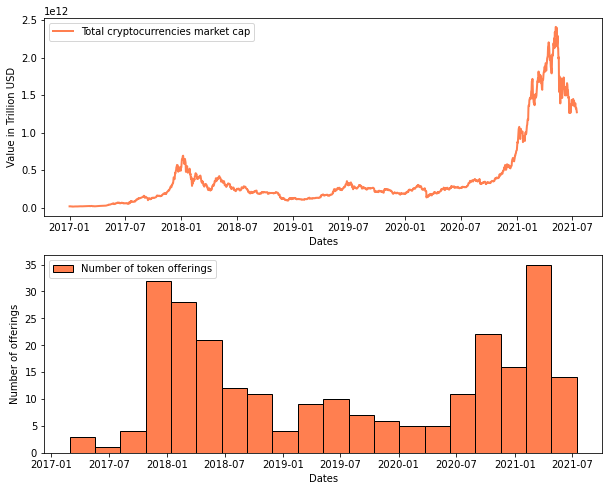

In [53]:
fig, ax = plt.subplots(2,figsize=(10,8))


ax[0].plot(df_mktcap['close'].loc['2017':'2021'],color = 'coral', label = 'Total cryptocurrencies market cap',lw=2)
ax[1].hist(listdate[0],ec = 'k', bins = 20, color = 'coral',label = 'Number of token offerings')

ax[0].legend(fontsize = 'medium')
ax[1].legend(fontsize = 'medium')

ax[0].set_ylabel('Value in Trillion USD')
ax[1].set_ylabel('Number of offerings')

ax[0].set_xlabel('Dates')
ax[1].set_xlabel('Dates')


plt.grid(False)
plt.savefig('images/number and marketcap.png',  dpi=900,  transparent=True)
plt.savefig('images/number and marketcap.jpeg',  dpi=900)
plt.show()

In [54]:
#missing_ca = list(dict.fromkeys(result[2]))
#len(missing_ca)

In [62]:
result_nosharpe[1].set_index('dates',inplace =True)
result_sharpe1[1].set_index('dates',inplace =True)

## No sharpe

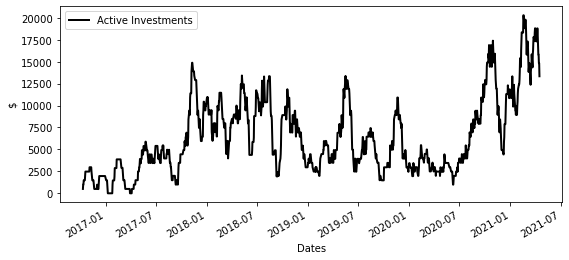

In [56]:
plt.figure(figsize=(9,4))
result_nosharpe[1]['active_investments'].plot(lw= 2, label = 'Active Investments', color ='k')

plt.legend(fontsize = 'medium')
plt.xlabel('Dates')
plt.ylabel('$')

plt.savefig('images/no_sharpe active investments.png',  dpi=400,  transparent=True)
plt.savefig('images/no_sharpe active investments.jpeg',  dpi=400)

plt.show()

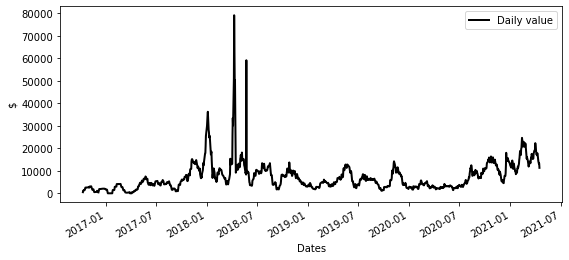

In [57]:
plt.figure(figsize=(9,4))

result_nosharpe[1]['daily_value'].plot(lw= 2, label = 'Daily value', color = 'k')

plt.xlabel('Dates')
plt.ylabel('$')
plt.legend(fontsize = 'medium')



plt.savefig('images/no_sharpe daily value.png',  dpi=400,  transparent=True)
plt.savefig('images/no_sharpe daily value.jpeg',  dpi=400)
plt.show()

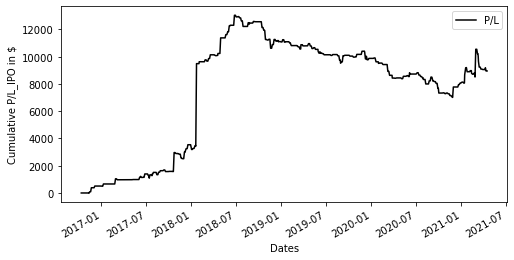

In [59]:

plt.figure(figsize=(8,4))

result_nosharpe[1]['realised_P/L_IPO'].plot(label = 'P/L',color = 'k')
plt.xlabel('Dates')
plt.ylabel('Cumulative P/L_IPO in $')
plt.legend(fontsize = 'medium')



plt.savefig('images/no_sharpe OnlyIPOPF.png',  dpi=400,  transparent=True)
plt.savefig('images/no_sharpe OnlyIPOPF.jpeg',  dpi=400)
plt.show()

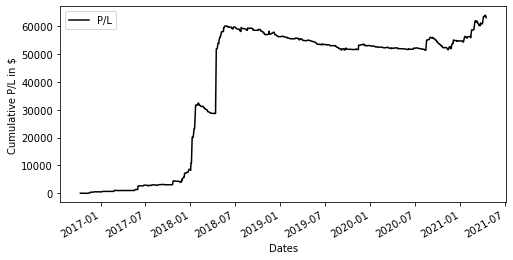

In [60]:
plt.figure(figsize=(8,4))

result_nosharpe[1]['realised_P/L'].plot(label = 'P/L', color = 'k')
plt.xlabel('Dates')
plt.ylabel('Cumulative P/L in $')
plt.legend(fontsize = 'medium')



plt.savefig('images/no_sharpe PL total.png',  dpi=400,  transparent=True)
plt.savefig('images/no_sharpe PL total.jpeg',  dpi=400)
plt.show()

## CAPM sharpe 1

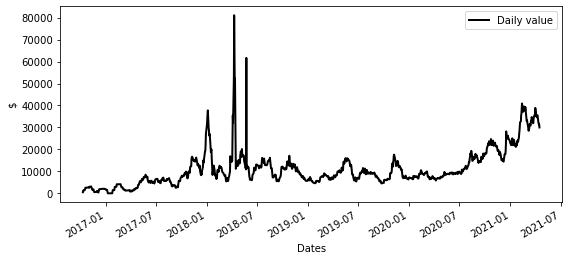

In [63]:
plt.figure(figsize=(9,4))

result_sharpe1[1]['daily_value'].plot(lw= 2, label = 'Daily value', color = 'k')

plt.xlabel('Dates')
plt.ylabel('$')
plt.legend(fontsize = 'medium')



plt.savefig('images/CAPM sharpe1 daily value.png',  dpi=400,  transparent=True)
plt.savefig('images/CAPM sharpe1 daily value.jpeg',  dpi=400)
plt.show()

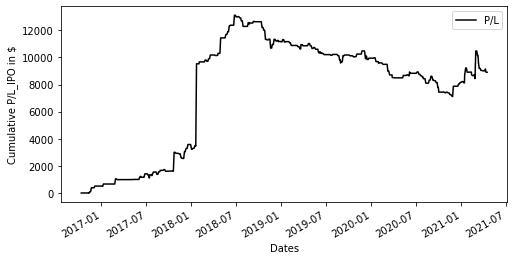

In [64]:
plt.figure(figsize=(8,4))

result_sharpe1[1]['realised_P/L_IPO'].plot(label = 'P/L',color = 'k')
plt.xlabel('Dates')
plt.ylabel('Cumulative P/L_IPO in $')
plt.legend(fontsize = 'medium')



plt.savefig('images/CAPM sharpe1 OnlyIPOPF.png',  dpi=400,  transparent=True)
plt.savefig('images/CAPM sharpe1 OnlyIPOPF.jpeg',  dpi=400)
plt.show()

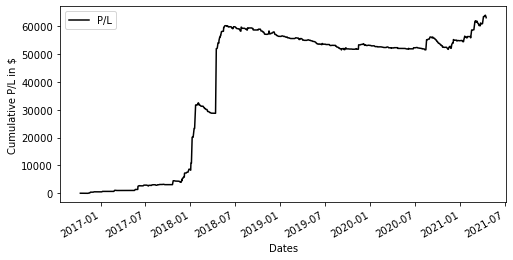

In [65]:
plt.figure(figsize=(8,4))

result_sharpe1[1]['realised_P/L'].plot(label = 'P/L', color = 'k')
plt.xlabel('Dates')
plt.ylabel('Cumulative P/L in $')
plt.legend(fontsize = 'medium')



plt.savefig('images/CAPM sharpe1PL total.png',  dpi=400,  transparent=True)
plt.savefig('images/CAPM sharpe1PL total.jpeg',  dpi=400)
plt.show()

## mean hist returns

In [66]:
result_sharpe1 = my_portfolio(df_ipo = adj, df_ca = df_ca, df_info = df, 
                      expected_return = 'mean_hist',sharpe_pf = 1,
                      window = 30)

In [67]:
result_sharpe1[1].set_index('dates',inplace =True)

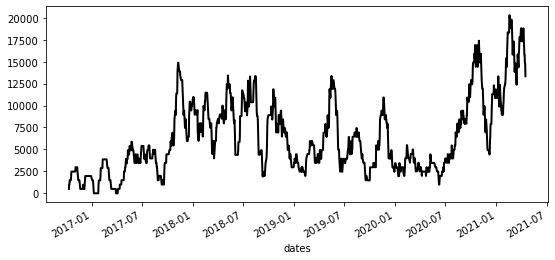

In [68]:
plt.figure(figsize=(9,4))
result_nosharpe[1]['active_investments'].plot(lw= 2, label = 'sharpe = \'no\'', color ='k')

#plt.savefig('images/mh no_sharpe active investments.png',  dpi=400,  transparent=True)
#plt.savefig('images/mh no_sharpe active investments.jpeg',  dpi=400)

plt.show()

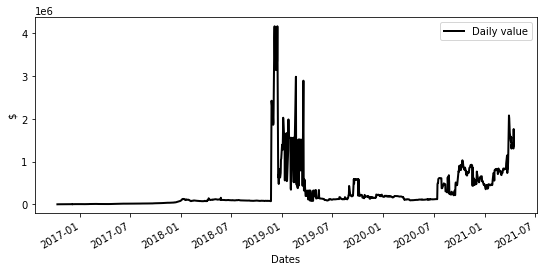

In [69]:
plt.figure(figsize=(9,4))

result_sharpe1[1]['daily_value'].plot(lw= 2, label = 'Daily value', color = 'k')

plt.xlabel('Dates')
plt.ylabel('$')
plt.legend(fontsize = 'medium')



plt.savefig('images/mh sharpe1 daily value.png',  dpi=400,  transparent=True)
plt.savefig('images/mh sharpe1 daily value.jpeg',  dpi=400)
plt.show()

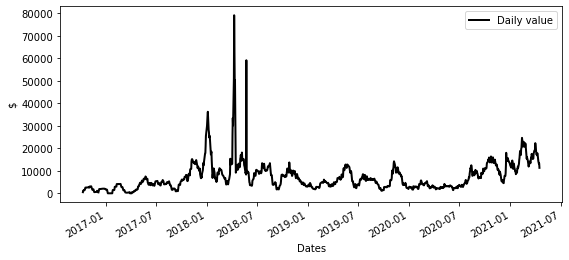

In [70]:
plt.figure(figsize=(9,4))

result_nosharpe[1]['daily_value'].plot(lw= 2, label = 'Daily value', color = 'k')

plt.xlabel('Dates')
plt.ylabel('$')
plt.legend(fontsize = 'medium')



plt.savefig('images/mh no_sharpe daily value.png',  dpi=400,  transparent=True)
plt.savefig('images/mh no_sharpe daily value.jpeg',  dpi=400)
plt.show()

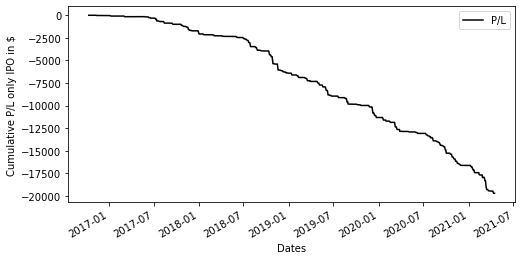

In [71]:
plt.figure(figsize=(8,4))

result_sharpe1[1]['realised_P/L_IPO'].plot(label = 'P/L',color = 'k')
plt.xlabel('Dates')
plt.ylabel('Cumulative P/L only IPO in $')
plt.legend(fontsize = 'medium')



plt.savefig('images/mh sharpe1 OnlyIPOPF.png',  dpi=400,  transparent=True)
plt.savefig('images/mh sharpe1 OnlyIPOPF.jpeg',  dpi=400)
plt.show()

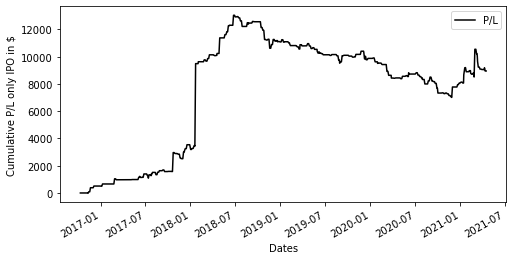

In [72]:

plt.figure(figsize=(8,4))

result_nosharpe[1]['realised_P/L_IPO'].plot(label = 'P/L',color = 'k')
plt.xlabel('Dates')
plt.ylabel('Cumulative P/L only IPO in $')
plt.legend(fontsize = 'medium')



plt.savefig('images/mh no_sharpe OnlyIPOPF.png',  dpi=400,  transparent=True)
plt.savefig('images/mh no_sharpe OnlyIPOPF.jpeg',  dpi=400)
plt.show()

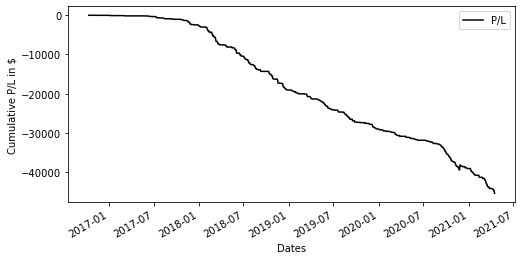

In [73]:
plt.figure(figsize=(8,4))

result_sharpe1[1]['realised_P/L'].plot(label = 'P/L', color = 'k')
plt.xlabel('Dates')
plt.ylabel('Cumulative P/L in $')
plt.legend(fontsize = 'medium')



plt.savefig('images/mh sharpe1 PL total.png',  dpi=400,  transparent=True)
plt.savefig('images/mh sharpe1 PL total.jpeg',  dpi=400)
plt.show()

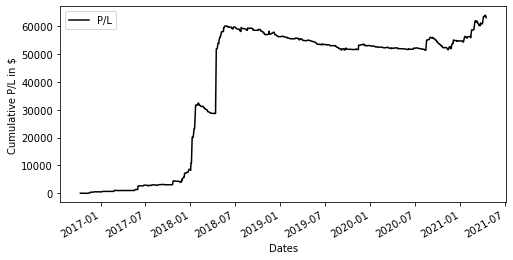

In [74]:
plt.figure(figsize=(8,4))

result_nosharpe[1]['realised_P/L'].plot(label = 'P/L', color = 'k')
plt.xlabel('Dates')
plt.ylabel('Cumulative P/L in $')
plt.legend(fontsize = 'medium')



plt.savefig('images/mh no_sharpe PL total.png',  dpi=400,  transparent=True)
plt.savefig('images/mh no_sharpe PL total.jpeg',  dpi=400)
plt.show()